In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import operator
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import Input
from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv1D, Conv2D, Dense, BatchNormalization, Flatten, MaxPooling2D, Activation
from keras.layers.core import Dense, Dropout
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

In [5]:
#download the weather images and put them in a directory
path = '/data/notebook_files/Multi-class Weather Dataset'
folders = os.listdir(path)
print(folders)

['Sunrise', 'Shine', 'Cloudy', 'Rain']


In [6]:
#this will load in the pictures and rescale them to 250x250pixels

datagenerator = ImageDataGenerator(rescale=1/255, validation_split=0.2)
train_generator = datagenerator.flow_from_directory(
    path,
    target_size=(250 , 250),
    batch_size=32,
    subset='training',
)

test_generator = datagenerator.flow_from_directory(
    path,
    target_size=(250 , 250),
    batch_size=32,
    subset='validation',
)

Found 901 images belonging to 4 classes.
Found 224 images belonging to 4 classes.


In [7]:
#this is a CNN to categorize the weather images

inputs = Input(shape=(250, 250, 3))

x = Conv2D(32, (5,5), activation = 'relu')(inputs)
x = MaxPooling2D(3,3)(x)
x = Conv2D(64, (5,5) , activation = 'relu')(x)
x = MaxPooling2D((3,3))(x)
x = Conv2D(128 , (5,5) , activation = 'relu')(x)
x = MaxPooling2D(3,3)(x)
x = Flatten()(x)
x = Dropout(0.5, seed = 5)(x)
x = Dense(128 , activation = 'relu')(x)

outputs = Dense(4, activation = 'softmax')(x)

model:Model = Model(inputs=inputs, outputs=outputs)

In [23]:
#compile and run the model
#how many epochs are required to generate an accurate model?

model.compile(optimizer="Adam", loss="mean_squared_error", metrics=["accuracy"])
model.fit(
    train_generator, 
    epochs = 40, #<----FILL THIS IN!
    steps_per_epoch = train_generator.n // train_generator.batch_size,
    validation_data = test_generator,
    validation_steps = test_generator.n // test_generator.batch_size,
)

Epoch 1/40
28/28 [==============================] - 70s 2s/step - loss: 0.0587 - accuracy: 0.8458 - val_loss: 0.0744 - val_accuracy: 0.8125
Epoch 2/40
28/28 [==============================] - 118s 4s/step - loss: 0.0496 - accuracy: 0.8723 - val_loss: 0.0697 - val_accuracy: 0.8214
Epoch 3/40
28/28 [==============================] - 215s 8s/step - loss: 0.0372 - accuracy: 0.9010 - val_loss: 0.0737 - val_accuracy: 0.7902
Epoch 4/40
28/28 [==============================] - 204s 7s/step - loss: 0.0327 - accuracy: 0.9183 - val_loss: 0.0742 - val_accuracy: 0.8259
Epoch 5/40
28/28 [==============================] - 222s 8s/step - loss: 0.0348 - accuracy: 0.9091 - val_loss: 0.0511 - val_accuracy: 0.8750
Epoch 6/40
28/28 [==============================] - 209s 7s/step - loss: 0.0299 - accuracy: 0.9183 - val_loss: 0.0511 - val_accuracy: 0.8616
Epoch 7/40
28/28 [==============================] - 257s 9s/step - loss: 0.0353 - accuracy: 0.9091 - val_loss: 0.0534 - val_accuracy: 0.8527
Epoch 8/40
28/

In [24]:
results = pd.DataFrame(model.history.history)

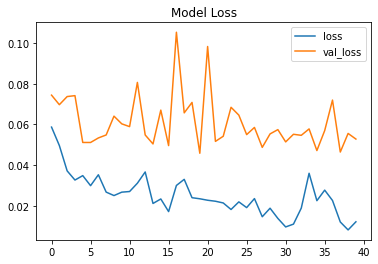

In [25]:
results[['loss','val_loss']].plot(title='Model Loss')
plt.savefig('./loss.png')

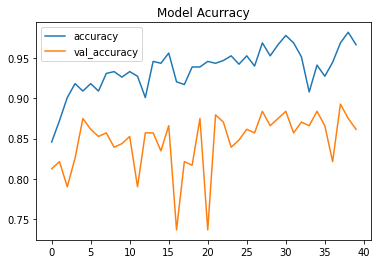

In [26]:
results[['accuracy','val_accuracy']].plot(title='Model Acurracy')
plt.savefig('./accuracy.png')

Watching the graphs, we can tell the model has converged.

In [27]:
# Print the accuracy and loss
print("Accuracy: {}, Val_Accuracy: {}".format(results['accuracy'].iloc[-1], results['val_accuracy'].iloc[-1]))
print("Loss: {}, Val_Loss: {}".format(results['loss'].iloc[-1], results['val_loss'].iloc[-1]))

Accuracy: 0.9666283130645752, Val_Accuracy: 0.8616071343421936
Loss: 0.01214126031845808, Val_Loss: 0.05281626433134079


11/11 [==============================] - 7s 618ms/step


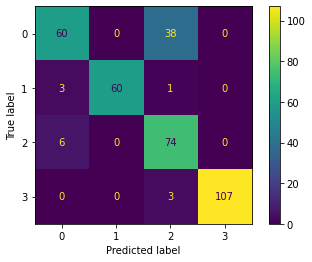

In [28]:
# collect n batches of images and display the confusion matrix for them.

class_names = ['Cloudy', 'Rain', 'Shine', 'Sunrise']
n = 10 #<--you can change the number of batches selected.

image_batch, classes_batch = next(test_generator)

for batch in range(n):
    temp = next(test_generator)
    image_batch = np.concatenate((image_batch, temp[0]))
    classes_batch = np.concatenate((classes_batch, temp[1]))

classes_batch = classes_batch
y_predict = model.predict(image_batch)

#Confusion matrix for training data
cm = confusion_matrix(y_pred = [np.argmax(x) for x in y_predict], y_true = [np.argmax(x) for x in classes_batch])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [29]:
#This function will display a number of random images as well as the predictions for the type of weather.

def predict_one(model, num_images = None):  
    image_batch, classes_batch = next(test_generator)
    predicted_batch = model.predict(image_batch)
    for k in range(0,image_batch.shape[0] if num_images is None else num_images):
        image = image_batch[k]
        real_class = class_names[np.argmax(classes_batch[k])]
        predicted_class = class_names[np.argmax(predicted_batch[k])]
        value_predicted = predicted_batch[k]
        isTrue = (real_class == predicted_class)
        plt.figure(k)
        plt.title(str("Correct Prediction" if isTrue else "Incorrect Prediction") + ' - class: ' + real_class + ' - ' + 'predicted: ' + predicted_class + str(value_predicted))
        plt.axis('off')
        plt.savefig('./' + real_class + '_' + predicted_class + '_' + str(value_predicted) + '.png')
        plt.imshow(image)

1/1 [==============================] - 1s 651ms/step


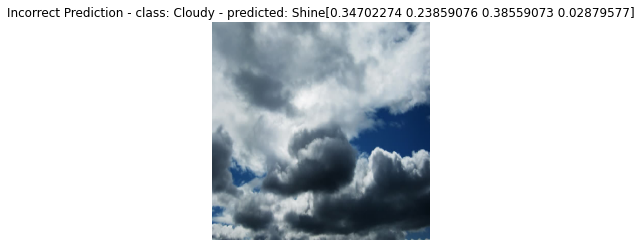

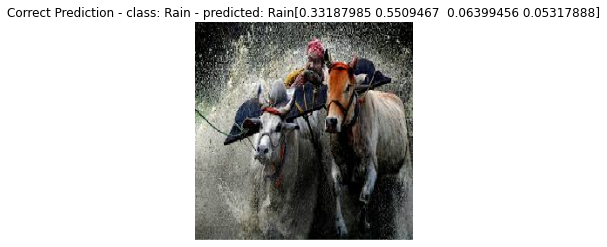

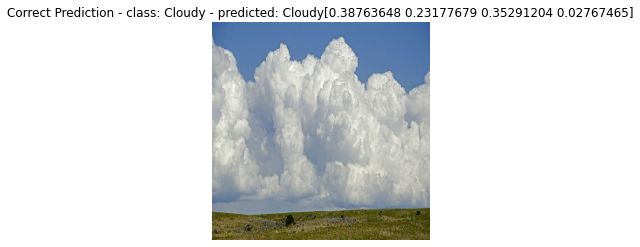

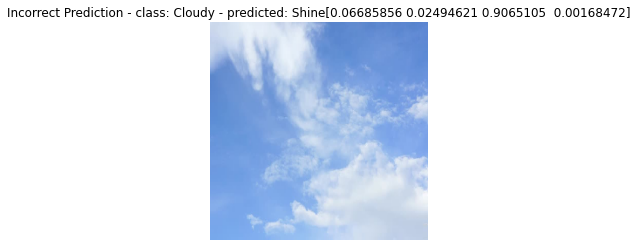

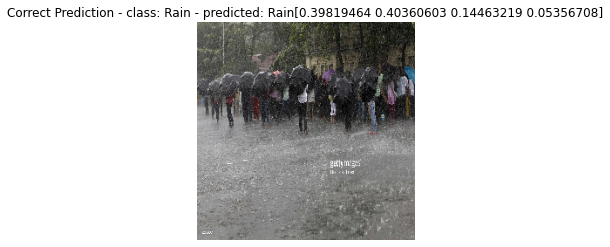

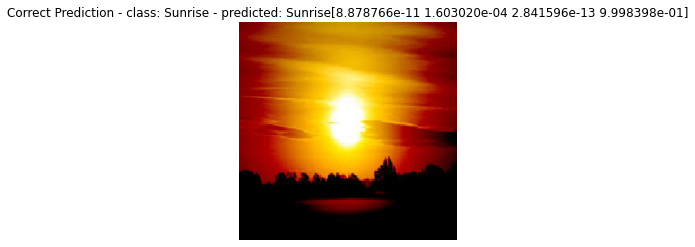

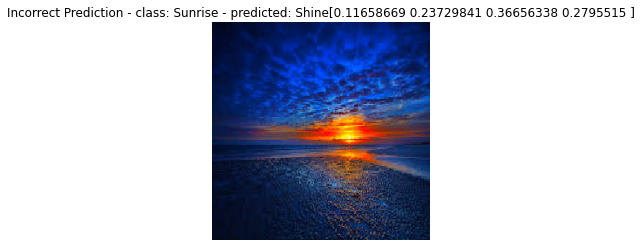

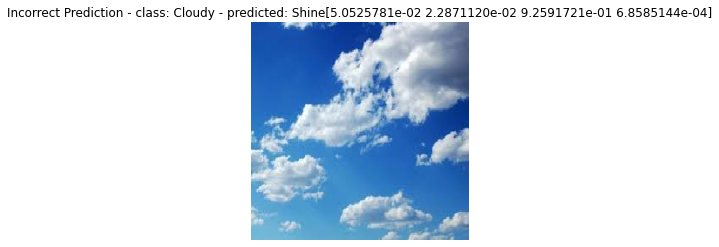

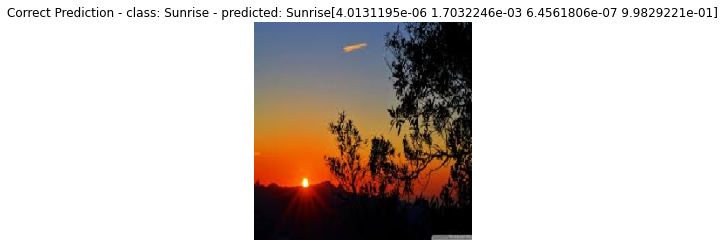

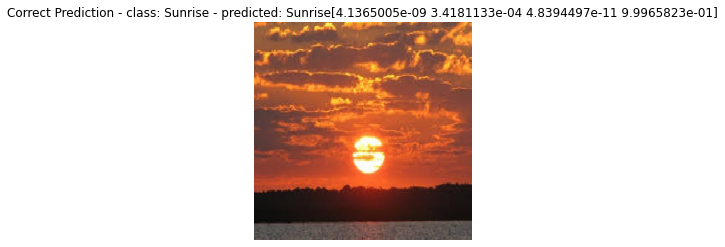

In [12]:
predict_one(model, 10) #<--you can show multiple pictures with this command. Just fill in the number you want to see.

The model attributed the wrong weather condition to 4 images out of 10. In particular, it seems it has difficulties distinguishing cloudy and shine.